# Import and Gather Images,Labels as Train/Test

## Install addons and import libraries

In [ ]:
pip install validators

In [ ]:
pip install -U tensorflow-addons

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard
import typing
import warnings
from urllib import request
from http import client
import io
import pkg_resources
import validators
import numpy as np
import scipy as sp
import cv2
import PIL
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input , Concatenate , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import pathlib
import shutil
from tensorflow import keras
from tensorflow.keras import datasets, layers
import math
import zipfile
import glob
import pandas as pd
import tensorflow_addons as tfa

## Import CSV file with Labels for Downstream classification

### Specify File path to CSV in Gdrive

In [ ]:
num_classes = 4
# input_shape = (224, 224, 3)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#CSV file should be present in your Google Drive
mouse_csv_file=pd.read_csv('/content/drive/MyDrive/Cropped_Images_Wound_Stage_Probabilities_Cleaned_No_Ties.csv',index_col='Image')

### Convert CSV to DataFrame object

In [ ]:
mouse_csv_file[["hemostasis", "inflammatory",'proliferative','maturation']] = mouse_csv_file[["hemostasis", "inflammatory",'proliferative','maturation']].apply(pd.to_numeric)

In [ ]:
cropped_df=pd.DataFrame(mouse_csv_file.idxmax(axis=1),columns=['stage'])

In [ ]:
#Replace the stage name with numbers
cropped_df['stage'].replace(["hemostasis", "inflammatory",'proliferative','maturation'],
                        [0, 1,2,3], inplace=True)

In [ ]:
x=cropped_df.loc['Day 8_A8-4-L.png']
print(x[0])

2


## Load Images From Gdrive

### Load Directories

In [ ]:
# Old directory contains wound images with splint
# Circle_Cropped_images_Sid contains preprocessed images without splint

directory_train_old = '/content/drive/MyDrive/Wound_images/train/'
directory_test_old = '/content/drive/MyDrive/Wound_images/test/'
directory_val_old = '/content/drive/MyDrive/Wound_images/val/'
directory_new='/content/drive/MyDrive/Circle_Cropped_images_Sid/'

In [ ]:
file_list_test=os.listdir(directory_test_old)
file_list_train=os.listdir(directory_train_old)
file_list_val=os.listdir(directory_val_old)

In [ ]:
def create_train_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_train:
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])
  return dataset, labels


def create_test_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_test:
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])

  return dataset, labels

def create_val_dataset():
  labels=[]
  dataset=[]
  for file_path in file_list_val:    
    dataset.append(directory_new + file_path)
    labels.append(cropped_df.loc[file_path][0])
  return dataset, labels

In [ ]:
#These variables hold the image file paths along with the labels from the Labels Dataframe
train_X_dir , train_Y_dir = create_train_dataset()
test_X_dir , test_Y_dir = create_test_dataset()
val_X_dir , val_Y_dir = create_val_dataset()

### Load Images from directories

In [ ]:
image_size = 224

In [ ]:
#Pil Loader loads images and resizes them to 224 x 224
def pil_loader_black(path, target_image_shape=(image_size,image_size)):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = PIL.Image.open(f)
    img = np.array(img)
    img = cv2.resize(img, target_image_shape)
    return img

In [ ]:
def load_dataset(pairs,labels):
  images=[]
  image_labels = []
  for i in range(len(pairs)):
    file_dir  = pathlib.Path(pairs[i])
    
    if file_dir.exists():
        images += [pil_loader_black(pairs[i])]      
        image_labels += [labels[i]]
  return images,image_labels

In [ ]:
train_images,train_labels=load_dataset(train_X_dir , train_Y_dir)
test_images,test_labels = load_dataset(test_X_dir , test_Y_dir)
val_images,val_labels = load_dataset(val_X_dir , val_Y_dir)

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 0_Y8-3-R.png


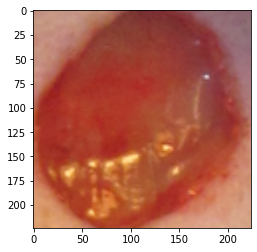

In [ ]:
#Test an image and its directory
print(test_X_dir[2])
plt.imshow(test_images[2])

In [ ]:
#Reshape the images and labels array to Numpy

train_X , train_Y = np.array(train_images),np.array(train_labels).astype('float64').reshape((-1,1))
test_X , test_Y = np.array(test_images),np.array(test_labels).astype('float64').reshape((-1,1))
val_X , val_Y = np.array(val_images),np.array(val_labels).astype('float64').reshape((-1,1))

# Specify Parameters for Vision Transformer and Model

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 50
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Define MultiHeadAttention Class and add a DummyLayer which returns weights for Attention maps

## Define Classes

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        #attention takes three inputs: queries, keys, and values,
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        #use the product between the queries and the keys 
        #to know "how much" each element is the sequence is important with the rest
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        #resulting vector, score is divided by a scaling factor based on the size of the embedding
        #scaling fcator is square root of the embeding dimension
        scaled_score = score / tf.math.sqrt(dim_key)
        #the attention scaled_score is then softmaxed
        weights = tf.nn.softmax(scaled_score, axis=-1)
        #Attention(Q, K, V ) = softmax[(QK)/√dim_key]V
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
         
        batch_size = tf.shape(inputs)[0]
        #MSA takes the queries, keys, and values  as input from the previous layer 
        #and projects them using the three linear layers.
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        #self attention of different heads are concatenated  
        output = self.combine_heads(concat_attention)
        return output , weights                                                

In [ ]:
class DummyLayer(tf.keras.layers.Layer):
    def __init__(self):
      super(DummyLayer, self).__init__()
        
    def call(self,encoded_patches,weights1):
      return encoded_patches, weights1                    

## Define Augmentataion Layer and add Positional Embedding , ClassToken and MLP

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.01),
        layers.RandomZoom(
            height_factor=0.1, width_factor=0.1
        ),
        layers.RandomContrast(0.3)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_X)

In [ ]:
class AddPositionEmbsSid(tf.keras.layers.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=True,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)

In [ ]:
# @tf.keras.utils.register_keras_serializable()
class ClassTokenSid(tf.keras.layers.Layer):
    """Append a class token to an input layer."""

    def build(self, input_shape):
        cls_init = tf.zeros_initializer()
        print("Build called")
        self.hidden_size = input_shape[-1]
        self.cls = tf.Variable(
            name="cls",
            initial_value=cls_init(shape=(1, 1, self.hidden_size), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls, [batch_size, 1, self.hidden_size]),
            dtype=inputs.dtype,
        )
        return tf.concat([cls_broadcasted, inputs], 1)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Create Model Object of ViT Classifier

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size , 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    #Create Patches
    augmented = tf.keras.layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
    )(augmented)
    #Reshape the augemented images to projection dimension
    y = tf.keras.layers.Reshape((augmented.shape[1] * augmented.shape[2], projection_dim))(augmented)
    #Add the class Token
    y = ClassTokenSid(name="class_token")(y)
    #Append the Positional Embeddings
    encoded_patches = AddPositionEmbsSid(name="Transformer/posembed_input")(y)
    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output , weights = MultiHeadSelfAttention(
            num_heads=num_heads, embed_dim=projection_dim
        )(x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
    
        encoded_patches , weight_final = DummyLayer()(encoded_patches,weights)
    
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model 

# Run Experiments

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ],
    )

    history = model.fit(
        x=train_X,
        y=train_Y,
        batch_size=batch_size,
        epochs=50,
        validation_data=(val_X, val_Y)
        
    )


    _, accuracy = model.evaluate(test_X, test_Y)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Build called
Epoch 1/50
24/24 [==============================] - 22s 585ms/step - loss: 17.8063 - accuracy: 0.4084 - val_loss: 14.1121 - val_accuracy: 0.5312
Epoch 2/50
24/24 [==============================] - 13s 563ms/step - loss: 17.3800 - accuracy: 0.4188 - val_loss: 16.1486 - val_accuracy: 0.4688
Epoch 3/50
24/24 [==============================] - 13s 550ms/step - loss: 13.3720 - accuracy: 0.5288 - val_loss: 13.4208 - val_accuracy: 0.4375
Epoch 4/50
24/24 [==============================] - 13s 542ms/step - loss: 11.9572 - accuracy: 0.5079 - val_loss: 11.7352 - val_accuracy: 0.5625
Epoch 5/50
24/24 [==============================] - 13s 532ms/step - loss: 9.7418 - accuracy: 0.5654 - val_loss: 9.1575 - val_accuracy: 0.5312
Epoch 6/50
24/24 [==============================] - 13s 553ms/step - loss: 7.2759 - accuracy: 0.5759 - val_loss: 5.3302 - val_accuracy: 0.5625
Epoch 7/50
24/24 [==============================] - 13s 561ms/step - loss: 4.1098 - accuracy: 0.6283 - val_loss: 5.5491 -

# Attention Maps

## Visualize attention maps from train , test , val

### Define Read function to take in Model object and return image resized

In [ ]:
try:
    import PIL
    import PIL.Image
except ImportError:  # pragma: no cover
    PIL = None

ImageInputType = typing.Union[str, np.ndarray, "PIL.Image.Image", io.BytesIO]


def read(filepath_or_buffer: ImageInputType, size, timeout=None):
    """Read a file into an image object
    Args:
        filepath_or_buffer: The path to the file or any object
            with a `read` method (such as `io.BytesIO`)
        size: The size to resize the image to.
        timeout: If filepath_or_buffer is a URL, the timeout to
            use for making the HTTP request.
    """
    if PIL is not None and isinstance(filepath_or_buffer, PIL.Image.Image):
        return np.array(filepath_or_buffer.convert("RGB"))
    if isinstance(filepath_or_buffer, (io.BytesIO, client.HTTPResponse)):
        image = np.asarray(bytearray(filepath_or_buffer.read()), dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    elif isinstance(filepath_or_buffer, str) and validators.url(filepath_or_buffer):
        with request.urlopen(filepath_or_buffer, timeout=timeout) as r:
            return read(r, size=size)
    else:
        if not os.path.isfile(filepath_or_buffer):
            raise FileNotFoundError(
                "Could not find image at path: " + filepath_or_buffer
            )
        image = cv2.imread(filepath_or_buffer)
    if image is None:
        raise ValueError(f"An error occurred reading {filepath_or_buffer}.")
    # We use cvtColor here instead of just ret[..., ::-1]
    # in order to ensure that we provide a contiguous
    # array for later processing. Some hashers use ctypes
    # to pass the array and non-contiguous arrays can lead
    # to erroneous results.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return cv2.resize(image, (size, size))

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


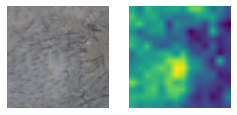

In [ ]:
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    reshaped = reshaped.mean(axis=1)
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')

new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))

attention_map = attention_map(model=vit_classifier, image=image)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(4,4))


ax1.axis('off')
ax2.axis('off')

_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## View and Save original Image

In [ ]:
from google.colab import files

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

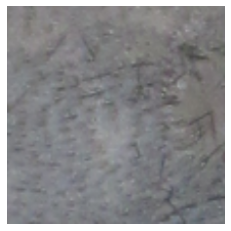

In [ ]:
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    
    size = model.input_shape[1]
    
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    reshaped = reshaped.mean(axis=1)

    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')

new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=vit_classifier, image=image)

fig,ax1 = plt.subplots(ncols=1,figsize=(4,4))
ax1.axis('off')
_ = ax1.imshow(image)
plt.savefig("Original file"+ new_file[49:63] +".png", bbox_inches='tight',pad_inches = 0)
files.download("Original file"+ new_file[49:63] +".png") 

## View and Save Aggregate Layer

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

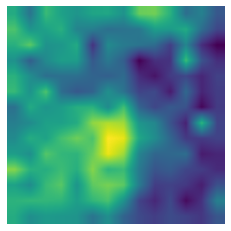

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    
    size = model.input_shape[1]
    
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    reshaped = reshaped.mean(axis=1)

    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')

new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=vit_classifier, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')
_ = ax2.imshow(attention_map)
plt.savefig(new_file[49:63]+" Aggregate "+".png" , bbox_inches='tight',pad_inches = 0)
files.download(new_file[49:63]+" Aggregate "+".png")

##  View and Save Layer 1

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

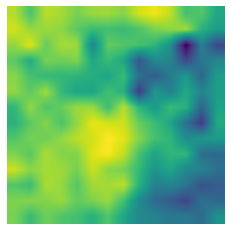

In [ ]:
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[0]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    reshaped = reshaped.mean(axis=1)
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')

new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))
attention_map = attention_map(model=vit_classifier, image=image)
fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')
_ = ax2.imshow(attention_map)

# Uncomment to download and save maps
# plt.savefig(new_file[49:63]+"Layer 1"+".png" , bbox_inches='tight',pad_inches = 0)
# files.download(new_file[49:63]+"Layer 1"+".png")

## Layer 2

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

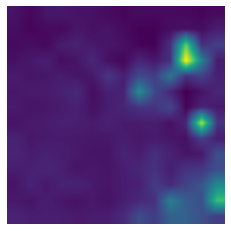

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
# from . import layers, vit


def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    size = model.input_shape[1]
    
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    
    X= img1[np.newaxis, :]
    
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[1]).predict(X)
    )
    
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    
    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
    
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result

dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')

new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))
attention_map = attention_map(model=vit_classifier, image=image)
fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
_ = ax2.imshow(attention_map)


#Uncomment to download attention maps

# plt.savefig(new_file[49:63]+"Layer 2" +".png", bbox_inches='tight',pad_inches = 0)
# files.download(new_file[49:63]+"Layer 2" +".png")

## Layer 3

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

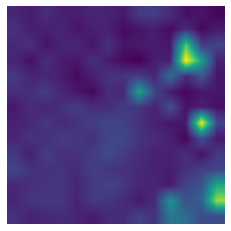

In [ ]:
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    
    size = model.input_shape[1]
    
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[2]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    reshaped = reshaped.mean(axis=1)

    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=vit_classifier, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
ax2.axis('off')

_ = ax2.imshow(attention_map)

# Uncomment to download and save maps
# plt.savefig(new_file[49:63]+"Layer 3" +".png", bbox_inches='tight',pad_inches = 0)
# files.download(new_file[49:63]+"Layer 3" +".png")

## Layer 4

/content/drive/MyDrive/Circle_Cropped_images_Sid/Day 15_Y8-3-R.png
Img 1 shape is  (224, 224, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

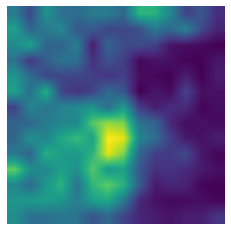

In [ ]:
def attention_map(model, image):
    
    size = model.input_shape[1]
    
    grid_size = int(np.sqrt(model.layers[15].output_shape[0][-2] - 1))
    
    img1=cv2.resize(image, (size, size))
    print("Img 1 shape is ",img1.shape)
    X= img1[np.newaxis, :]
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, DummyLayer)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs[3]).predict(X)
    )
    
    num_layers = weights.shape[0]
    num_heads = weights.shape[1]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1 )
    )
    reshaped = reshaped.mean(axis=1)

    reshaped = reshaped + np.eye(reshaped.shape[2])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]
    
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])


    get_mask=True
    mask = v[0, 1:].reshape(grid_size, grid_size)

    if get_mask:
      result = cv2.resize(mask / mask.max(), (image_size,image_size))
    else:
      mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
          ..., np.newaxis
          ]
      result= (mask * image).astype("uint8")

    return result




dir_new ='/content/drive/MyDrive/Circle_Cropped_images_Sid/'
test_file_list= os.listdir('/content/drive/MyDrive/Wound_images/test/')
new_file=dir_new+test_file_list[14]
print(new_file)
img = PIL.Image.open(new_file)
image = np.array(img)
image = cv2.resize(image, (image_size,image_size))


attention_map = attention_map(model=vit_classifier, image=image)

fig,ax2 = plt.subplots(ncols=1,figsize=(4,4))
_ = ax2.imshow(attention_map)
# Uncomment to download and save maps

# plt.savefig(new_file[49:63]+"Layer 4" +".png", bbox_inches='tight',pad_inches = 0)
# files.download(new_file[49:63]+"Layer 4" +".png")